In [4]:
%%writefile Ind_MACD_TRE.py

import sys
import os 
module_path = os.path.abspath(os.path.join('..')) 
if module_path not in sys.path: 
    sys.path.append(module_path)


import numpy as np
import pandas as pd

import QUANTAXIS as QA

import Ind_Model_Base

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker



class MACD_JCSC(Ind_Model_Base.Ind_Model):
    optimum_param={'valid':False, 'main':'MACD', 'desition_direct':1, 'freq':'d','neutralize':{'enable':False,'static_mv':True}}
    
    def __init__(self,data, frequence=QA.FREQUENCE.DAY):
        super().__init__(data, 'MACD', frequence)
        

    def on_set_params_default(self):
        return {'SHORT':12,'LONG':26,'M':9}
    
        
    def on_indicator_structuring(self, data):
        #return data.add_func(self.MACD_JCSC,**self.pramas)
        return self.excute_for_multicode(data, self.kernel, **self.pramas)
    
    def on_desition_structuring(self, data, ind_data):
        """
        1.DIF向上突破DEA,res为1，买入信号参考。
        2.DIF向下跌破DEA,res为-1，卖出信号参考。
        """
        return pd.DataFrame({'res':ind_data['CROSS_JC'] + ind_data['CROSS_SC']*-1})
        
    def kernel(self,dataframe,SHORT=12,LONG=26,M=9):
        CLOSE=dataframe.close
        DIFF =QA.EMA(CLOSE,SHORT) - QA.EMA(CLOSE,LONG)
        DEA = QA.EMA(DIFF,M)
        MACD =2*(DIFF-DEA)
        
        if self.fast_mode:
            return pd.DataFrame({'main':MACD}) 

        CROSS_JC=QA.CROSS(DIFF,DEA)
        CROSS_SC=QA.CROSS(DEA,DIFF)

        return pd.DataFrame({'MACD':MACD,'DIFF':DIFF,'DEA':DEA,'MACD':MACD,'CROSS_JC':CROSS_JC,'CROSS_SC':CROSS_SC})

    def plot(self,figsize=(1120/72,420/72)):
        fig = plt.figure(figsize=figsize)
        groups = self.ind_df.groupby(level=1)
        for idx,item in enumerate(groups):
            inds_ = item[1].reset_index('code',drop=True)
            ax = fig.add_subplot(len(groups),1,idx+1)
            
            
            ##axis不转成字符串的话，bar和line的x轴有时候对不上，原因未知
            
            formater = '%Y%m%d' if self.is_low_frequence else '%Y%m%d %H%M%S'
            index_ = [pd.to_datetime(x).strftime(formater) for x in inds_.index.values]
#             d = item[1].reset_index(('date','code'),drop=True)

            ax.set_title(item[0],color='r', loc ='left', pad=-10) 
            DD = inds_[['DIFF','DEA']]
            DD.index = index_
            DD.plot(kind='line', ax=ax)
            macd = inds_['MACD']
            macd.index = index_
            macd.plot(kind='bar', ax=ax)
            ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
            plt.xticks(rotation = 0)
    

    

Overwriting Ind_MACD_JCSC.py


In [2]:
from tools.Test_Tools import FactorTest

# %load_ext autoreload
# %autoreload 1
# %aimport Test_Tools

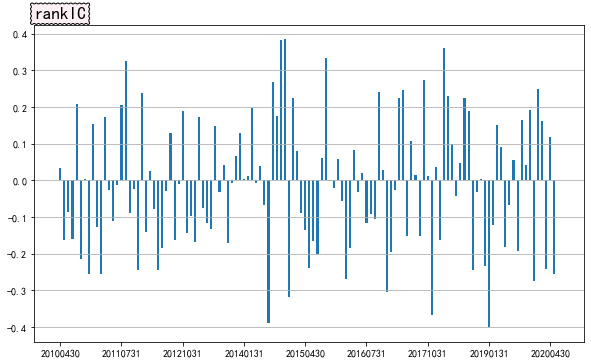

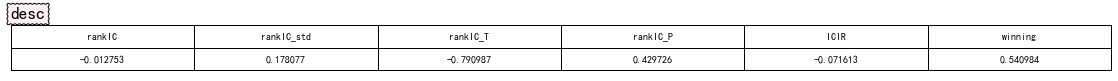

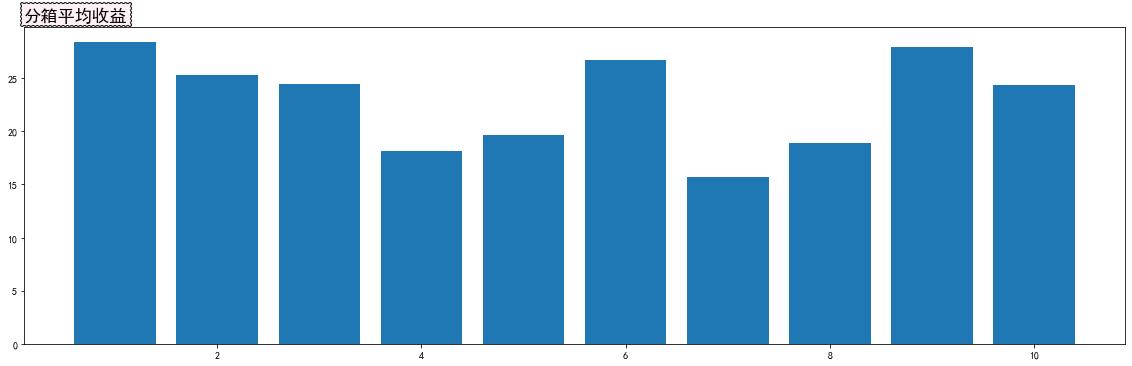

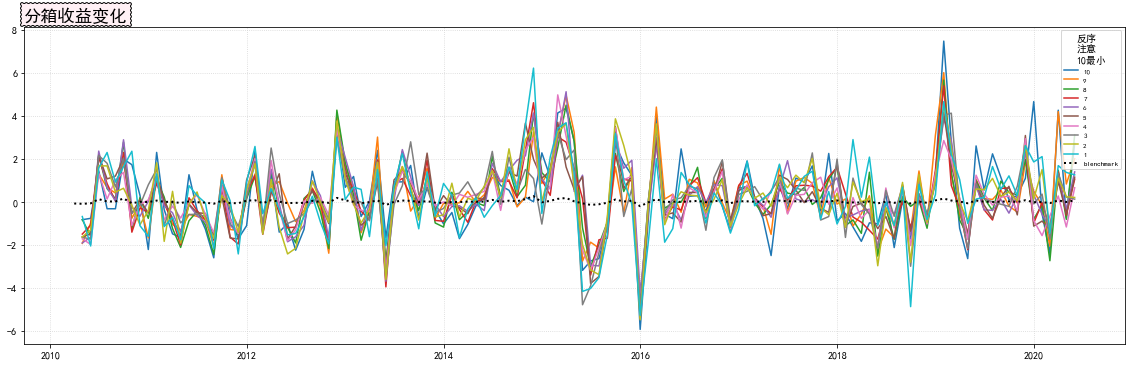

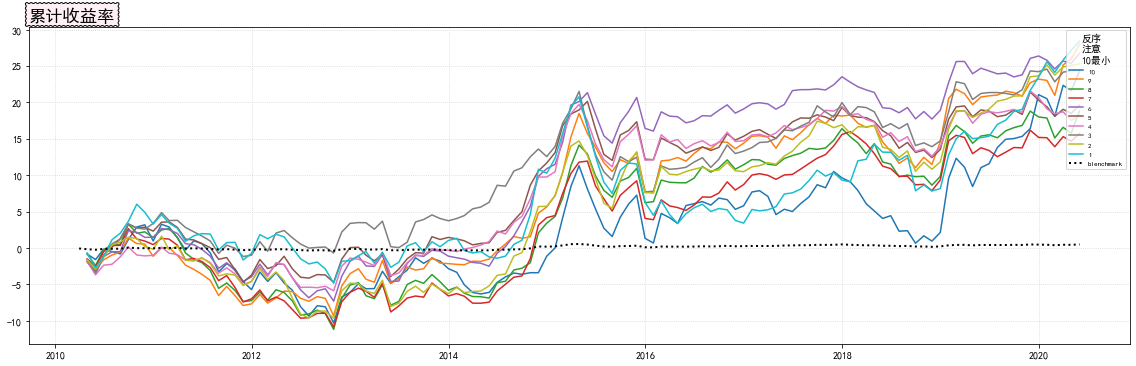

Wall time: 56.8 s


In [2]:
%%time
test = FactorTest(MACD_JCSC, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':True,'static_mv':True})

test.process()
test.plot()

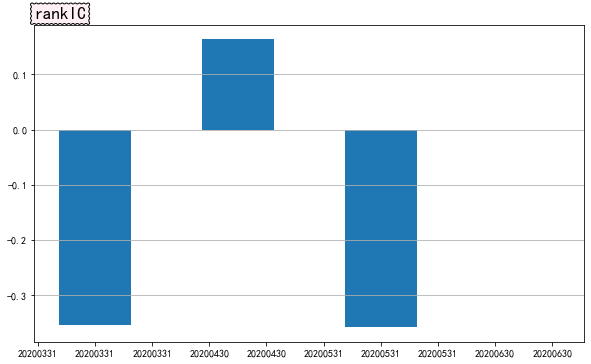

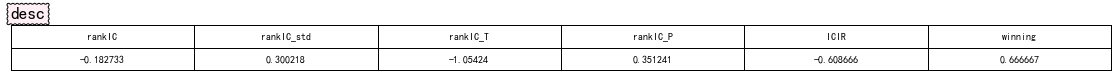

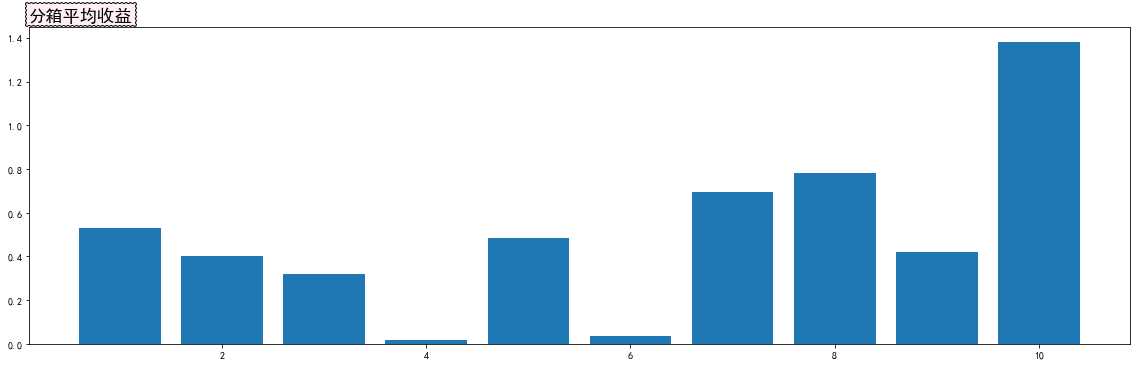

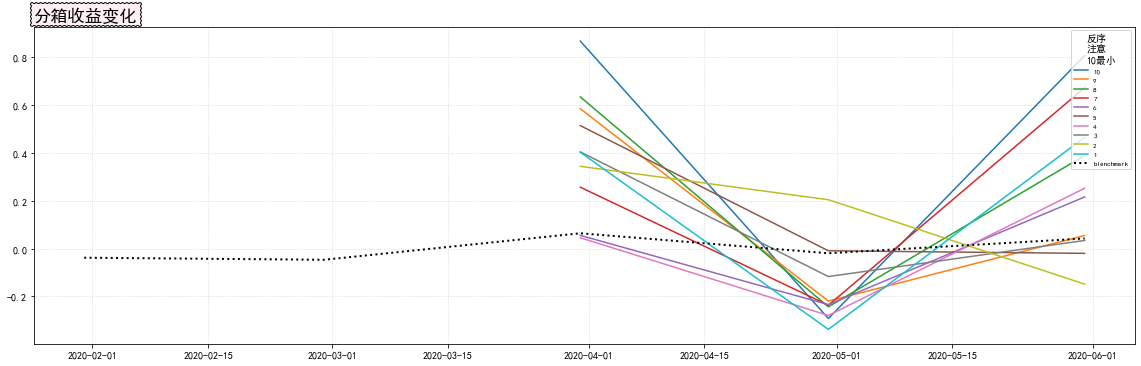

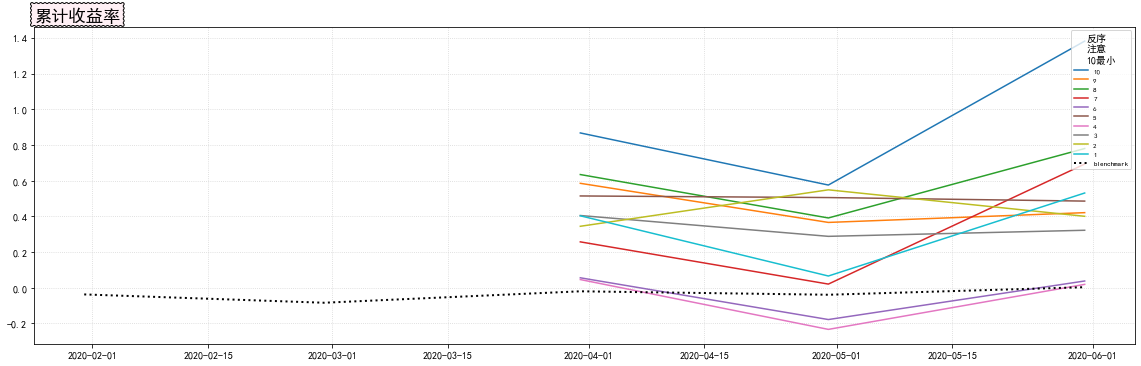

Wall time: 3.02 s


In [20]:
%%time
test = FactorTest(MACD_JCSC, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':True,'static_mv':False, 'liquidity_mv':False})

test.process()
test.plot()

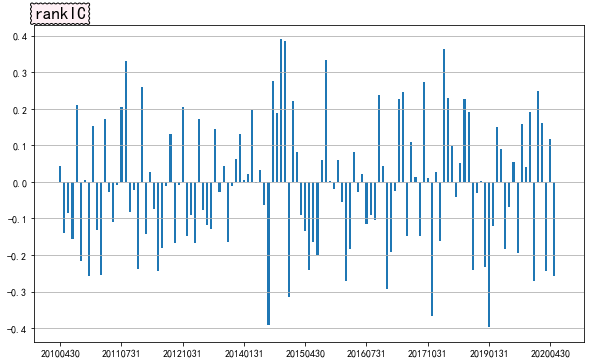

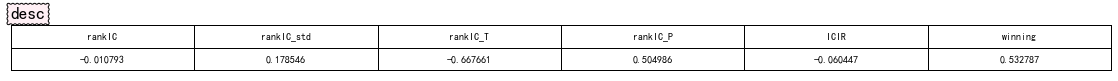

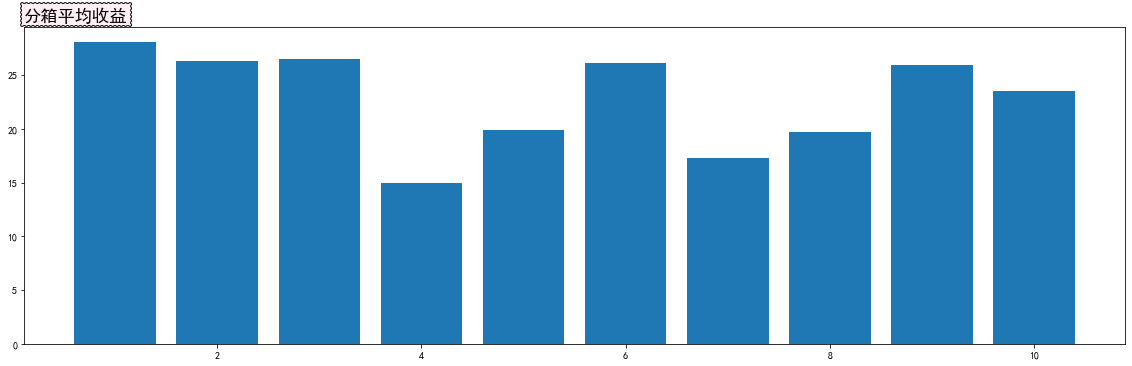

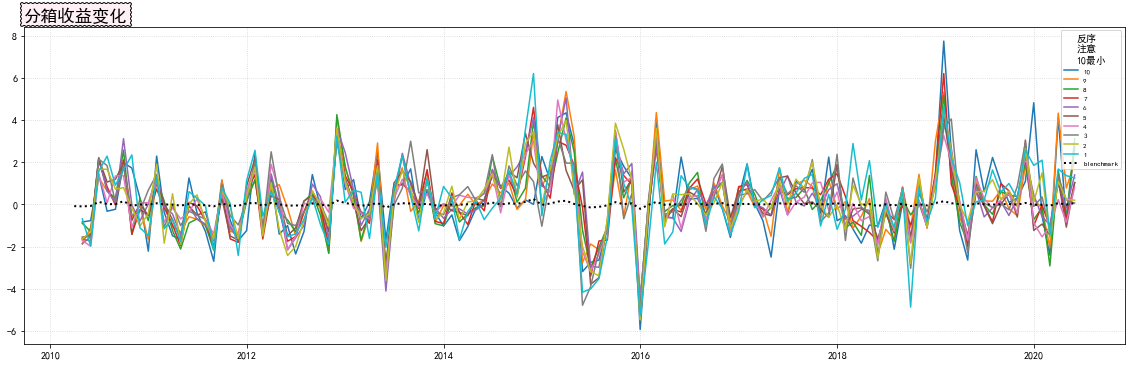

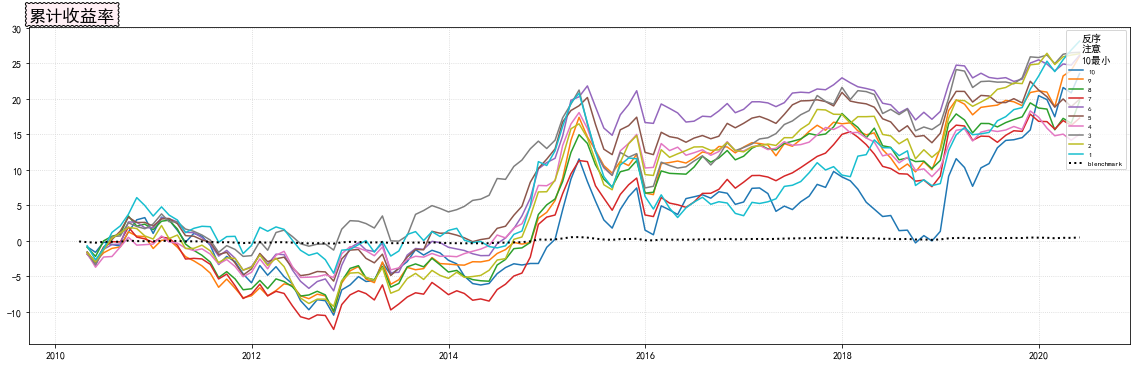

Wall time: 45.7 s


In [2]:
%%time
test = FactorTest(MACD_JCSC, sample='沪深300',freq="m",end='2020-06-29',gap=2500,only_main=True,neutralize={'enable':True,'static_mv':False})

test.process()
test.plot()

In [21]:
%%time
r = test.get_ind_binned_ret_avg().rank(ascending=False)
print(r)
group_label = r.index.tolist()
print(np.corrcoef(group_label,r))

r = test.get_ind_binned_ret_cumsum().groupby(level=0).agg('rank',ascending=False)
print(r)
group_label = r.index.get_level_values(1).tolist()
rank = r.values.reshape(1,-1)[0]
print(np.corrcoef(group_label,rank))

# def binned_evaluate(self):
#     self.get_ind_binned_ret_avg()

group_label
10     6.0
9      2.0
8      8.0
7      9.0
6      4.0
5      7.0
4     10.0
3      3.0
2      5.0
1      1.0
dtype: float64
[[1.         0.26060606]
 [0.26060606 1.        ]]
                        ret_forward
date       group_label             
2010-04-30 10                   2.0
           9                    9.0
           8                    3.0
           7                    8.0
           6                    5.0
...                             ...
2020-05-31 5                    7.0
           4                   10.0
           3                    3.0
           2                    5.0
           1                    1.0

[1220 rows x 1 columns]
[[1.        0.3657228]
 [0.3657228 1.       ]]
Wall time: 247 ms
